# environment
https://gymnasium.farama.org/environments/classic_control/cart_pole/

 1. action space (2 - left, or right)
 2. observation_space - 4 (cart position, velocity, pole angle, pole angular velocity)

In [35]:
# Inspired by https://github.com/dennybritz/reinforcement-learning

# Works best w/ multiply RBF kernels at var=0.05, 0.1, 0.5, 1.0

In [36]:
import gymnasium as gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

In [37]:
env = gym.make('CartPole-v1')

In [38]:
env.observation_space.sample()

array([-2.4526746e+00, -1.0427746e+38,  9.3328223e-02, -1.2868207e+38],
      dtype=float32)

In [39]:
env.action_space.n, env.action_space.sample()

(2, 1)

In [40]:
class SGDRegressor:
  def __init__(self, D):
    self.w = np.random.randn(D) / np.sqrt(D)
    self.lr = 0.1

  def partial_fit(self, X, Y):
    self.w += self.lr*(Y - X.dot(self.w)).dot(X)

  def predict(self, X):
    return X.dot(self.w)

In [41]:
class FeatureTransformer:
  def __init__(self, env):
    # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    # NOTE!! state samples are poor, b/c you get velocities --> infinity
    observation_examples = np.random.random((20000, 4))*2 - 1
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
            ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
            ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
            ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
            ])
    feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))

    self.dimensions = feature_examples.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer

  def transform(self, observations):
    scaled = self.scaler.transform(observations)
    return self.featurizer.transform(scaled)


In [42]:
# Holds one SGDRegressor for each action
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer
    for i in range(env.action_space.n):
      model = SGDRegressor(feature_transformer.dimensions)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    result = np.stack([m.predict(X) for m in self.models]).T
    return result

  def update(self, s, a, G):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    self.models[a].partial_fit(X, [G])

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))

In [57]:
# returns a list of states_and_rewards, and the total reward
def play_one(model, env, eps, gamma):
  observation = env.reset()[0]
  done = False
  iteration_died = 2001
  totalreward = 0
  iters = 0
  while not done and iters < 2000:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, trunc, info = env.step(action)
    
    if done:
        reward = -200
        #print("iteration died: ", iters)
        iteration_died = iters

    # update the model
    next = model.predict(observation)
    assert(next.shape == (1, env.action_space.n))
    G = reward + gamma*np.max(next[0])
    model.update(prev_observation, action, G)

    if reward == 1: # if we didn't change the reward to -200
      totalreward += reward
    else:
      died = True
    iters += 1

  return totalreward, iteration_died

In [58]:
ft = FeatureTransformer(env)
model = Model(env, ft)
gamma = 0.99

In [59]:
N = 500
num_died = 0
iteration_died = np.empty(N)
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward, iter_died = play_one(model, env, eps, gamma)
    iteration_died[n] = iter_died
    totalrewards[n] = totalreward
    if n % 100 == 0:
        print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())        

episode: 0 total reward: 12.0 eps: 1.0 avg reward (last 100): 12.0
episode: 100 total reward: 350.0 eps: 0.09950371902099892 avg reward (last 100): 124.26732673267327
episode: 200 total reward: 190.0 eps: 0.07053456158585983 avg reward (last 100): 242.5049504950495
episode: 300 total reward: 207.0 eps: 0.0576390417704235 avg reward (last 100): 198.56435643564356
episode: 400 total reward: 73.0 eps: 0.04993761694389223 avg reward (last 100): 184.13861386138615
avg reward for last 100 episodes: 190.38
total steps: 93915.0


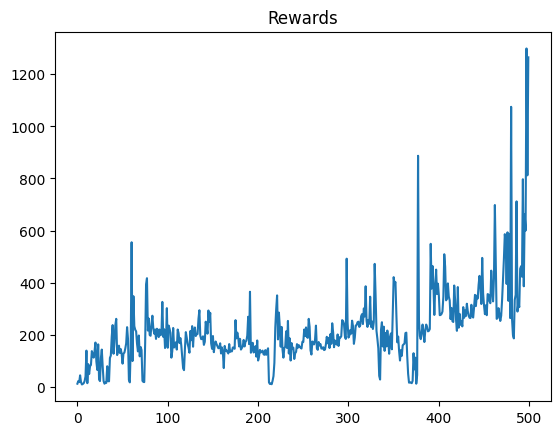

In [49]:
plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

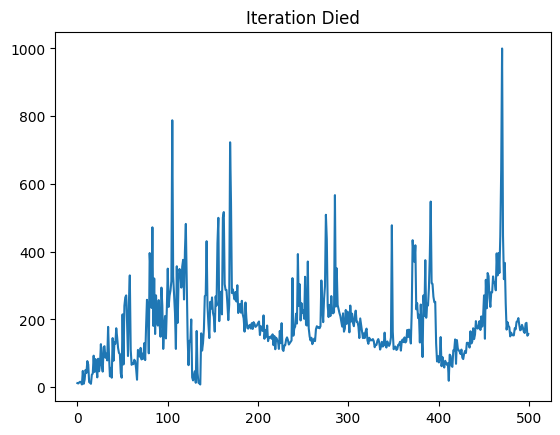

In [60]:
plt.plot(iteration_died)
plt.title("Iteration Died")
plt.show()

In [61]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

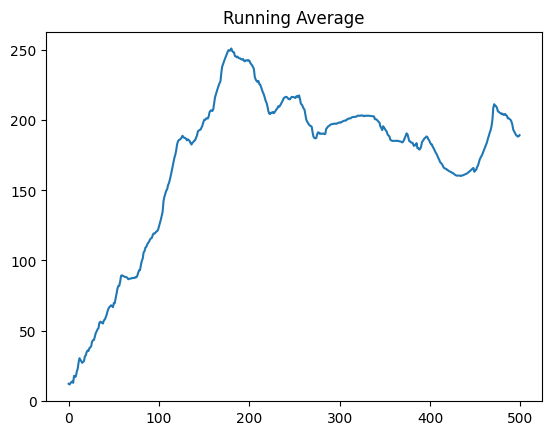

In [62]:
plot_running_avg(totalrewards)

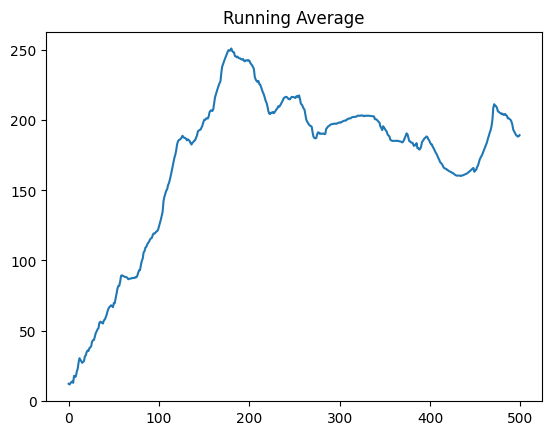

In [63]:
plot_running_avg(iteration_died)